In [2]:
import torch
import torchvision
from torchvision.transforms import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt


In [3]:
training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),

)

test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)


100%|██████████| 170498071/170498071 [00:13<00:00, 13021296.59it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


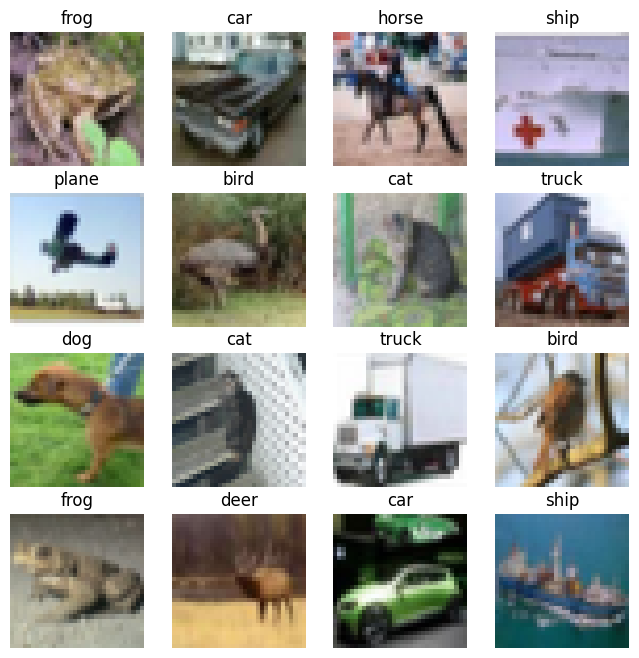

In [4]:
labels_map = ['plane',
              'car',
              'bird',
              'cat',
              'deer',
              'dog',
              'frog',
              'horse',
              'ship',
              'truck']

figure = plt.figure(figsize=(8,8))
cols, rows = 4,4
for i in range(1, cols * rows +1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()


In [5]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  # 클래스 초기화
  def __init__(self, data, transforms=None):
    # 데이터 저장
    self.data = data
    # 데이터에 적용할 전처리 함수 저장
    self.transforms = transforms

  # 데이터셋의 길이
  def __len__(self):
    return len(self.data)

  # 데이터셋에서 특정 인덱스의 데이터 가져오기
  def __getitem__(self, index):
    sample = self.data[index]
    # 변환 함수가 지정되어 있다면 샘플에 적용
    if self.transforms:
      sample = self.transforms(sample)

    return sample

train_dataset = CustomDataset(training_data)
test_dataset = CustomDataset(test_data)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [6]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


Label: 4


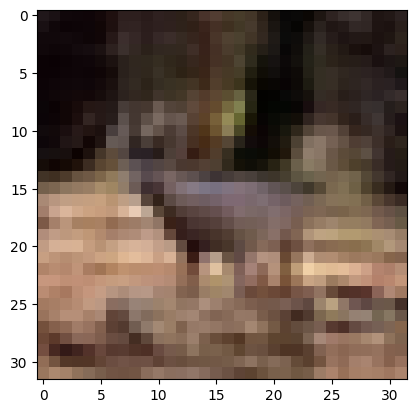

In [7]:
img = train_features[0]
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.show
print(f"Label: {label}")

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [62]:
import torch.nn as nn

class NerualNetwork(nn.Module):
  def __init__(self):
    super(NerualNetwork,self).__init__() ## nn.Module의 생성자를 호출하여 신경망 모듈 초기화
    self.cnn_layers = nn.Sequential(
        nn.Conv2d(3, 6, 5),      # 입력 채널 3, 출력 채널 6, 커널 크기 5
        nn.ReLU(),               # 활성화 함수
        # 2x2 크기의 윈도우 사용해서 최대 풀링 레이어 정의
        # 인접한 2x2 픽셀에서 가장 큰 값을 취하여 해상도를 절반으로 줄인다
        nn.MaxPool2d(2, 2),
        nn.Conv2d(6, 16, 5),     # 입력 채널 6, 출력 채널 16, 커널 크기 5
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(16, 32, 5),    # 입력 채널 16, 출력 채널 32, 커널 크기 5
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 5),    # 입력 채널 32, 출력 채널 64, 커널 크기 5
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
    )

  def forward(self,x):
    logits = self.cnn_layers(x)
    return logits


In [51]:
model = NerualNetwork().to(device)
print(model)

NerualNetwork(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
)


In [65]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [54]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred= model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [55]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X,y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred,y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \fake")

In [66]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.435778  [    0/50000]
loss: 1.531426  [ 6400/50000]
loss: 1.774353  [12800/50000]
loss: 1.429957  [19200/50000]
loss: 1.544170  [25600/50000]
loss: 1.546900  [32000/50000]
loss: 1.481714  [38400/50000]
loss: 1.486834  [44800/50000]
Test Error: 
 Accuracy: 48.4%, Avg loss: 1.443383 ake
Epoch 2
-------------------------------
loss: 1.261365  [    0/50000]
loss: 1.868300  [ 6400/50000]
loss: 1.312631  [12800/50000]
loss: 1.361861  [19200/50000]
loss: 1.181437  [25600/50000]
loss: 1.330878  [32000/50000]
loss: 1.325190  [38400/50000]
loss: 1.245389  [44800/50000]
Test Error: 
 Accuracy: 52.9%, Avg loss: 1.334541 ake
Epoch 3
-------------------------------
loss: 1.315858  [    0/50000]
loss: 0.977085  [ 6400/50000]
loss: 1.206340  [12800/50000]
loss: 1.495911  [19200/50000]
loss: 1.356778  [25600/50000]
loss: 1.314974  [32000/50000]
loss: 1.481658  [38400/50000]
loss: 1.086810  [44800/50000]
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.264596 

In [67]:
model.eval()
X, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
  x = X.to(device)
  pred = model(x)
  predicted, actual = labels_map[pred[0].argmax(0)], labels_map[y]
  print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "cat", Actual: "cat"
